# Demos: Lecture 8

In [1]:
import pennylane as qml
from pennylane import numpy as np
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
n_samples = 100

X, y = make_blobs(
    n_samples=n_samples, 
    centers=[[0.1, 0.2], [0.25, 0.4]], 
    cluster_std=0.05, 
    n_features=2,
    random_state=6
)

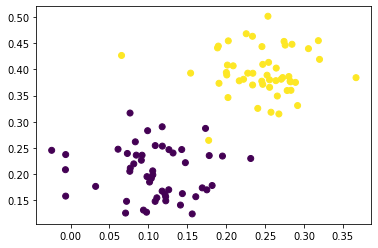

In [3]:
plot_data(X, y)

In [5]:
y

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [6]:
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)
y[y == 0] = -1

## Model 1: amplitude embedding

<img src="fig/model1.png" width="800px">

In [7]:
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def model_1(point, weights):
    qml.AmplitudeEmbedding(point, wires=0, normalize=True)
    qml.Rot(*weights, wires=0) 
    return qml.expval(qml.PauliX(0))

In [8]:
weights = np.random.normal(size=3)

In [9]:
weights

tensor([0.13614029, 2.35849636, 0.21222875], requires_grad=True)

In [10]:
def loss(weights):
    loss_sum = 0.0
    
    for idx in range(n_samples):
        point = X[idx]
        true_expval = y[idx]
        
        estimated_expval = model_1(point, weights)
        loss_sum += (estimated_expval - true_expval) ** 2
        
    return loss_sum / n_samples

In [11]:
our_preds = make_predictions(X, model_1, weights)

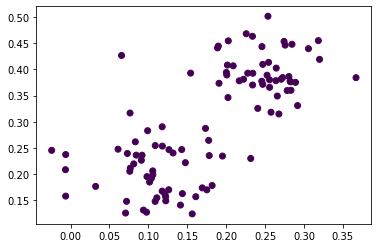

In [12]:
plot_data(X, our_preds)

In [13]:
compute_accuracy(y, our_preds)

0.5

In [14]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, model_1, weights)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
    loss_track.append(_loss)

Loss at iteration 0 = 1.8710638325244002  Accuracy = 0.5
Loss at iteration 5 = 1.5480290996943453  Accuracy = 0.5
Loss at iteration 10 = 1.1255370307964456  Accuracy = 0.44
Loss at iteration 15 = 0.995788109749746  Accuracy = 0.5
Loss at iteration 20 = 0.9733457857026454  Accuracy = 0.59
Loss at iteration 25 = 0.9691078980968968  Accuracy = 0.63
Loss at iteration 30 = 0.9679572586527445  Accuracy = 0.64
Loss at iteration 35 = 0.9673764589100224  Accuracy = 0.64
Loss at iteration 40 = 0.9669192108743669  Accuracy = 0.63
Loss at iteration 45 = 0.9665044504542323  Accuracy = 0.63
Loss at iteration 50 = 0.966117848881262  Accuracy = 0.63
Loss at iteration 55 = 0.9657571568731725  Accuracy = 0.63
Loss at iteration 60 = 0.9654220489591316  Accuracy = 0.63
Loss at iteration 65 = 0.965112267473075  Accuracy = 0.63
Loss at iteration 70 = 0.9648273201659546  Accuracy = 0.63
Loss at iteration 75 = 0.9645664660698702  Accuracy = 0.63
Loss at iteration 80 = 0.9643287530973487  Accuracy = 0.64
Loss 

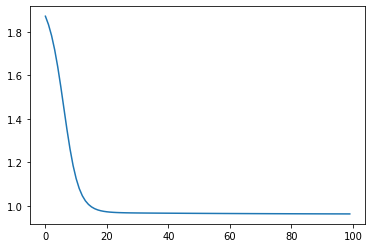

In [15]:
plt.plot(loss_track)

In [16]:
our_preds = make_predictions(X, model_1, weights)

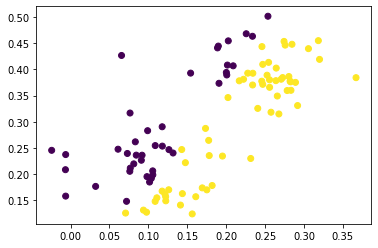

In [17]:
plot_data(X, our_preds)

In [18]:
compute_accuracy(our_preds, y)

0.64

## Model 2: angle embedding

<img src="fig/model2.png" width="800px"> 

In [21]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def model_2(point, weights):
    qml.AngleEmbedding(point, wires=[0, 1])
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliX(0))

In [19]:
weights = np.random.normal(size=(2, 3), requires_grad=True)

In [20]:
weights

tensor([[ 0.76336189, -0.48043149, -0.41359658],
        [-1.89642909, -1.04442207, -0.99743366]], requires_grad=True)

In [22]:
print(qml.draw(model_2, expansion_strategy="device")(X[0], weights))

0: ──RX(0.12)──Rot(0.76,-0.48,-0.41)──╭X─┤  <X>
1: ──RX(0.25)──Rot(-1.90,-1.04,-1.00)─╰●─┤     


In [23]:
loss = make_loss_function(X, y, model_2)

In [24]:
our_preds = make_predictions(X, model_2, weights)

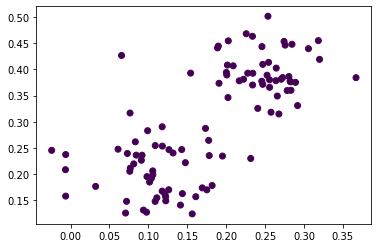

In [25]:
plot_data(X, our_preds)

In [26]:
compute_accuracy(our_preds, y)

0.5

In [27]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, model_2, weights)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
    loss_track.append(_loss)

Loss at iteration 0 = 1.0890620456604305  Accuracy = 0.5
Loss at iteration 5 = 0.9524987759217656  Accuracy = 0.5
Loss at iteration 10 = 0.921190535762134  Accuracy = 0.83
Loss at iteration 15 = 0.9093228237111424  Accuracy = 0.95
Loss at iteration 20 = 0.9012301761930481  Accuracy = 0.93
Loss at iteration 25 = 0.8947671600448088  Accuracy = 0.92
Loss at iteration 30 = 0.8895293623658749  Accuracy = 0.92
Loss at iteration 35 = 0.8853080795833967  Accuracy = 0.92
Loss at iteration 40 = 0.8819277699062753  Accuracy = 0.93
Loss at iteration 45 = 0.8792349793903809  Accuracy = 0.93
Loss at iteration 50 = 0.8770986492972225  Accuracy = 0.93
Loss at iteration 55 = 0.8754092248345082  Accuracy = 0.93
Loss at iteration 60 = 0.8740765778884126  Accuracy = 0.94
Loss at iteration 65 = 0.8730274375771266  Accuracy = 0.94
Loss at iteration 70 = 0.8722027687233462  Accuracy = 0.94
Loss at iteration 75 = 0.8715553299674181  Accuracy = 0.94
Loss at iteration 80 = 0.8710475155250827  Accuracy = 0.94
Lo

In [28]:
our_preds = make_predictions(X, model_2, weights)

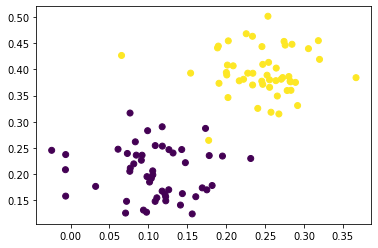

In [29]:
plot_data(X, y)

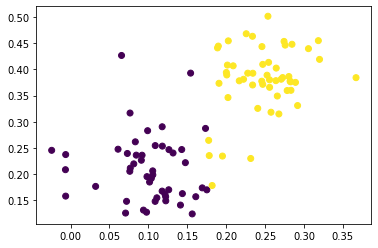

In [30]:
plot_data(X, our_preds)

In [31]:
compute_accuracy(our_preds, y)

0.94